<p style="font-family: Arial; font-size:2.75em;color:purple; font-style:bold"><br>
DM 3: Convex Optimization
</p><br> 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
import numpy as np
from tqdm import tqdm
from scipy.sparse import random as sparse_random
import matplotlib.pyplot as plt
from problems import CenteringProblem
from barrier import barr_method

## Retrieve LASSO function

First, we define those two small functions to retrieve the optimal solution $w^*$ and its associated function.

In [3]:
def retrieve_primal_w(X, y, v):
    
    # Initialize w
    n, d = X.shape
    w = np.zeros(d)
    
    # Retrieve nul coordinates
    nonnul_bool = np.array([0 if (np.isclose((X.T.dot(v)/lambda_)[i], 1, 1e-2) or np.isclose((X.T.dot(v)/lambda_)[i], -1, 1e-2)) 
                              else 1 for i in range(d)])
    nonnul_coords = np.nonzero(nonnul_bool)[0]
    
    # Retrieve other parameters
    new_X = X[:, nonnul_coords]
    nonnul_w = np.linalg.solve(new_X.T.dot(new_X), new_X.T).dot(y + v)
    
    # Get final w
    w = [nonnul_w[i] if nonnul_bool[i] else 0 for i in range(d)]
    
    return w

def compute_lasso(X, y, lambda_, w):
    return (1/2)*np.linalg.norm(X.dot(w)-y)**2 + lambda_*np.linalg.norm(w, ord=1)

In [4]:
if 0:
    print(1)

## Test on randomly generated data

We solve the LASSO problem with randomly generated data and analyze the results.

In [5]:
# Hyperparameters
n, d = 10, 200  # observations, dimensions
m = 2*d # To easily compute the duality gaps later
t0 = 1
eps = 1e-6
eps_centering = 1e-6
lambda_ = 10

# random data generation
X = np.random.rand(n, d)
true_w = sparse_random(d, 1).toarray().reshape(d)
noise = 0.01 * np.random.randn(n)
y = X.dot(true_w) + noise

# Create required arrays to the good shape
Q = 1/2*np.eye(n)
p = y.reshape((n, 1))
b = lambda_*np.ones((2*d, 1))
A = np.concatenate([X.T, -X.T])

# Initialize solution
v0 = np.zeros((n, 1))

## Check the impact of mu on:
- $f^*-f_i$ over iterations
- Duality gap $m/t$ over iterations
- Total number of Newton's iteration for the barrier problem
- **What we want:** the LASSO solution with $\hat{w}^*$. In order to check this item, we will compute $\|X\hat{w}^* - y\|_2^2 + \lambda \|\hat{w}^*\|_1$ for each $\mu$.

In [6]:
# For simplicity: 
centering_pb = CenteringProblem(Q, p, A, b, 1)

primal_sols = []
barrier_sols = []
lasso_sols = []
duality_gaps = []
newton_iterations = []

possible_mu = [2, 15, 50, 100, 150, 200, 250, 500, 1000]

for mu in possible_mu: 

    # Barrier method
    Vs, Ts, Cs = barr_method(Q, p, A, b, v0, eps, eps_centering, t=t0, mu=mu)
    
    # Retrieve information
    barrier_sols.append(np.array([centering_pb.compute_init_obj(v) for v in Vs]))
    duality_gaps.append([m/t for t in Ts])
    newton_iterations.append(Cs)
    primal_sols.append(retrieve_primal_w(X, y, np.array(Vs[-1].reshape(y.shape))))

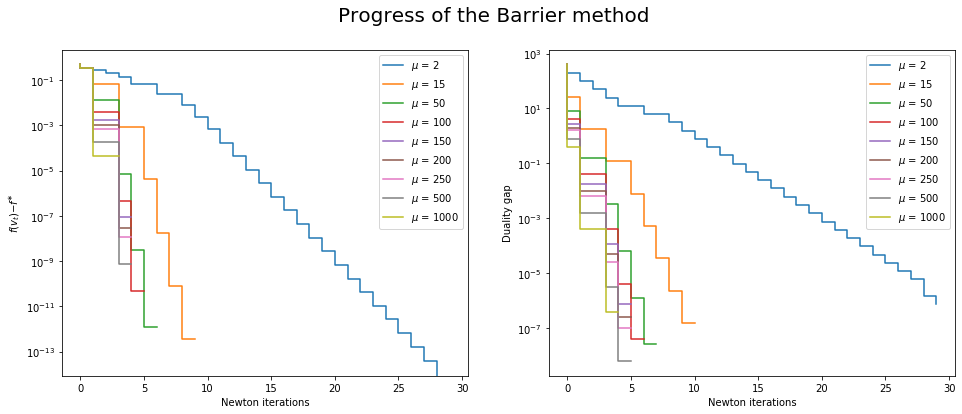

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

for i, sol in enumerate(barrier_sols):
    ax1.step(newton_iterations[i][:-1], sol[:-1] - sol[-1], label=f'$\mu$ = {possible_mu[i]}')

ax1.set_yscale('log')
ax1.set_ylabel('$f(v_t)−f^∗$')
ax1.set_xlabel('Newton iterations')
# ax1.set_title('Progress of the Barrier method', fontsize=20, pad=15)
ax1.legend()

for i, gap in enumerate(duality_gaps):
    ax2.step(newton_iterations[i], gap, label=f'$\mu$ = {possible_mu[i]}')

ax2.set_yscale('log')
ax2.set_ylabel('Duality gap')
ax2.set_xlabel('Newton iterations')
# ax2.set_title('Progress of the Barrier method', fontsize=20, pad=15)
ax2.legend()

fig.suptitle('Progress of the Barrier method', fontsize=20)

plt.show()

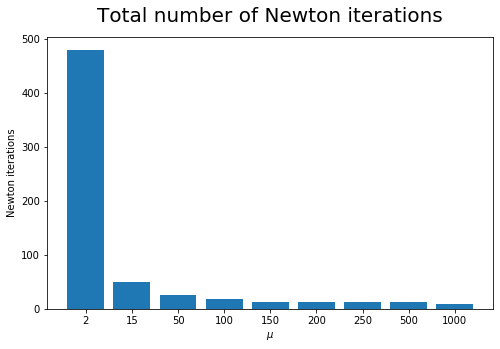

In [8]:
fig, ax= plt.subplots(figsize=(8, 5))

total_newton_iterations = [np.array(newton_it).sum() for newton_it in newton_iterations]
arange_list = np.arange(len(total_newton_iterations))
ax.bar(arange_list, total_newton_iterations)

ax.set_ylabel('Newton iterations')
ax.set_xlabel('$\mu$')
ax.set_title('Total number of Newton iterations', fontsize=20, pad=15)
ax.set_xticks(arange_list)
ax.set_xticklabels(possible_mu)

plt.show()

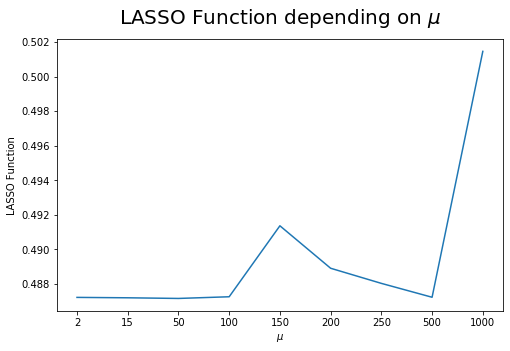

In [9]:
fig, ax= plt.subplots(figsize=(8, 5))

lasso_sols = [compute_lasso(X, y, lambda_, w_hat) for w_hat in primal_sols]
arange_list = np.arange(len(lasso_sols))
ax.plot(arange_list, lasso_sols)

ax.set_ylabel('LASSO Function')
ax.set_xlabel('$\mu$')
ax.set_title('LASSO Function depending on $\mu$', fontsize=20, pad=15)
ax.set_xticks(arange_list)
ax.set_xticklabels(possible_mu)

plt.show()

## Conclusion

- We have successfully recovered the primal solution $w^*$ in an **efficient** way. 
- It seems the more $\mu$ is high, the more efficient the algorithm is in terms of Newton iterations. However, it seems the LASSO objective is slightly higher for big $\mu$. Consequently, **$\mu=100$** seems to be a good compromise. 
- The higher bound $\frac{m}{t}$ on $f(v_t) - f^*$ is respected.